<a href="https://colab.research.google.com/github/hwkwon1114/PINN/blob/main/1D_Heat_Equation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import odeint

class HeatEquationPINN:
    def __init__(self, layers=[2, 64,64,64, 1], learning_rate=0.001):
        self.model = self.build_model(layers)
        lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
            learning_rate,
            decay_steps=1000,
            decay_rate=0.95,
            staircase=True)

        self.optimizer = tf.keras.optimizers.Adam(learning_rate=lr_schedule)
        self.loss_history = []
        self.alpha = 2.0


    def build_model(self, layers):
        inputs = tf.keras.Input(shape=(layers[0],))
        x = inputs
        for units in layers[1:-1]:
            x = tf.keras.layers.Dense(units, activation='tanh')(x)
        outputs = tf.keras.layers.Dense(layers[-1])(x)
        return tf.keras.Model(inputs=inputs, outputs=outputs)

    @tf.function
    def pde_loss(self, t, x):
        with tf.GradientTape(persistent=True) as tape2:
            tape2.watch(x)
            with tf.GradientTape(persistent=True) as tape1:
                tape1.watch([t, x])
                u = self.model(tf.stack([t, x], axis=1))
            u_t = tape1.gradient(u, t)
            u_x = tape1.gradient(u, x)
        u_xx = tape2.gradient(u_x, x)

        del tape1, tape2
        pde = u_t - self.alpha * u_xx
        return tf.reduce_mean(tf.square(pde))

    @tf.function
    def ic_loss(self, x_ic):
        t_ic = tf.zeros_like(x_ic)
        u_pred = self.model(tf.stack([t_ic, x_ic], axis=1))
        u_true = self.initial_condition(x_ic)
        return tf.reduce_mean(tf.square(u_pred - u_true))

    @tf.function
    def bc_loss(self, t_bc):
        T_hot = 100  # Hot end temperature
        T_cold = 20  # Cold end temperature

        x_left = tf.zeros_like(t_bc)
        x_right = tf.ones_like(t_bc) * 2.0

        u_left = self.model(tf.stack([t_bc, x_left], axis=1))
        u_right = self.model(tf.stack([t_bc, x_right], axis=1))

        return tf.reduce_mean(tf.square(u_left - T_hot) +
                            tf.square(u_right - T_cold))


    def initial_condition(self, x):
        # Initial condition is now uniformly 0°C
        return tf.zeros_like(x)

    def data_loss(self, t_data, x_data, u_data):
        u_pred = self.model(tf.stack([t_data, x_data], axis=1))
        return tf.reduce_mean(tf.square(u_pred - u_data))

    @tf.function
    def train_step(self, t, x, t_data=None, x_data=None, u_data=None):
        with tf.GradientTape() as tape:
            loss = 1 *self.pde_loss(t, x) + 10* self.ic_loss(x) + 10* self.bc_loss(t)
            if t_data is not None:
                loss += self.data_loss(t_data, x_data, u_data)

        gradients = tape.gradient(loss, self.model.trainable_variables)
        self.optimizer.apply_gradients(zip(gradients, self.model.trainable_variables))
        return loss

    def train(self, epochs, n_points=100, data=None):
        for epoch in range(epochs):
            t = tf.random.uniform((n_points, 1), 0, 1)
            x = tf.random.uniform((n_points, 1), 0, 2)

            if data is not None:
                t_data, x_data, u_data = data
                loss = self.train_step(t, x, t_data, x_data, u_data)
            else:
                loss = self.train_step(t, x)

            self.loss_history.append(loss.numpy())

            if epoch % 100 == 0:
                print(f"Epoch {epoch}, Loss: {loss.numpy():.6f}")

Stability parameter (should be ≤ 0.5): 12.12626262626263
Adjusted nt from 100 to 2402 for stability
Epoch 0, Loss: 107347.281250
Epoch 100, Loss: 71627.960938
Epoch 200, Loss: 60811.265625
Epoch 300, Loss: 51854.273438
Epoch 400, Loss: 43731.015625
Epoch 500, Loss: 37682.300781
Epoch 600, Loss: 30815.722656
Epoch 700, Loss: 26910.578125
Epoch 800, Loss: 22985.099609
Epoch 900, Loss: 18448.611328
Epoch 1000, Loss: 15464.387695
Epoch 1100, Loss: 15181.781250
Epoch 1200, Loss: 10715.486328
Epoch 1300, Loss: 7924.717773
Epoch 1400, Loss: 6969.757812
Epoch 1500, Loss: 7007.301270
Epoch 1600, Loss: 5124.701660
Epoch 1700, Loss: 4986.654785
Epoch 1800, Loss: 4479.362305
Epoch 1900, Loss: 4240.058594
Epoch 2000, Loss: 2447.228516
Epoch 2100, Loss: 3555.970215
Epoch 2200, Loss: 2579.298828
Epoch 2300, Loss: 2770.095215
Epoch 2400, Loss: 2440.148438
Epoch 2500, Loss: 2224.684082
Epoch 2600, Loss: 2240.554688
Epoch 2700, Loss: 1639.772583
Epoch 2800, Loss: 1018.715454
Epoch 2900, Loss: 1634.88378

Text(0.5, 1.0, 'PINN Prediction')

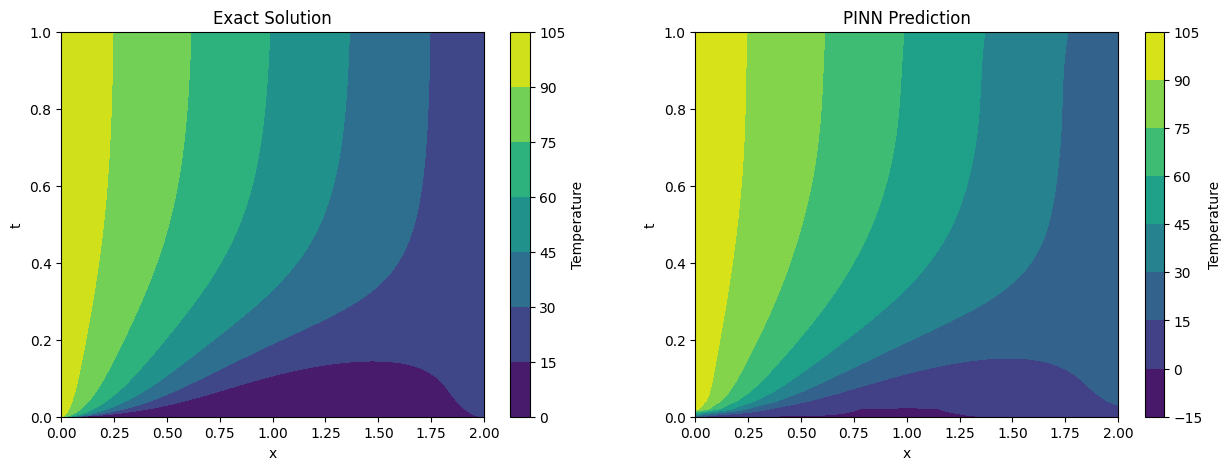

In [2]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import odeint

def generate_heat_data(nx=50, nt=100, alpha=2.0, t_final=1.0, T_hot=100, T_cold=20):
    x = np.linspace(0, 2, nx)
    dx = x[1] - x[0]
    t = np.linspace(0, t_final, nt)
    dt = t[1] - t[0]

    # Check stability condition
    stability_parameter = alpha * dt / (dx**2)
    print(f"Stability parameter (should be ≤ 0.5): {stability_parameter}")

    if stability_parameter > 0.5:
        nt_new = int(np.ceil(t_final / (0.5 * dx**2 / alpha)))
        t = np.linspace(0, t_final, nt_new)
        dt = t[1] - t[0]
        solution = np.zeros((nt_new, nx))
        print(f"Adjusted nt from {nt} to {nt_new} for stability")
    else:
        solution = np.zeros((nt, nx))

    # Initial condition: all points start at 0°C
    solution[0,:] = 0.0

    # Set boundary conditions
    solution[:,0] = T_hot   # Left boundary (x=0) fixed at T_hot
    solution[:,-1] = T_cold # Right boundary (x=2) fixed at T_cold

    # Solve using explicit finite difference method
    for n in range(0, len(t)-1):
        # Interior points only
        solution[n+1,1:-1] = solution[n,1:-1] + alpha * dt/dx**2 * \
                         (solution[n,2:] - 2*solution[n,1:-1] + solution[n,:-2])

    # Generate scattered data points
    n_samples = 200
    t_scattered = np.random.uniform(0, t_final, n_samples)
    x_scattered = np.random.uniform(0, 2, n_samples)

    # Interpolate solution for scattered points
    t_idx = np.searchsorted(t, t_scattered)
    x_idx = np.searchsorted(x, x_scattered)
    u_scattered = solution[t_idx, x_idx]

    # Add noise
    noise_level = 0.01
    u_scattered += noise_level * np.std(u_scattered) * np.random.randn(n_samples)

    return (t_scattered.reshape(-1, 1).astype(np.float32),
            x_scattered.reshape(-1, 1).astype(np.float32),
            u_scattered.reshape(-1, 1).astype(np.float32),
            solution.astype(np.float32),
            x.astype(np.float32),
            t.astype(np.float32))

# Modify plotting to handle different sized arrays
def plot_comparison(x_grid, t_grid, exact_solution, pinn_model):
    plt.figure(figsize=(15, 5))

    # Plot exact solution
    plt.subplot(131)
    plt.contourf(x_grid, t_grid, exact_solution)
    plt.colorbar(label='Temperature')
    plt.xlabel('x')
    plt.ylabel('t')
    plt.title('Exact Solution')

    # Generate PINN prediction on the same grid as exact solution
    X, T = np.meshgrid(x_grid, t_grid)
    X_flat = X.flatten().reshape(-1, 1)
    T_flat = T.flatten().reshape(-1, 1)
    U_pred = pinn_model(np.stack([T_flat, X_flat], axis=1)).numpy()
    U_pred = U_pred.reshape(X.shape)

    # Plot PINN prediction
    plt.subplot(132)
    plt.contourf(x_grid, t_grid, U_pred)
    plt.colorbar(label='Temperature')
    plt.xlabel('x')
    plt.ylabel('t')
    plt.title('PINN Prediction')

    # Plot error
    plt.subplot(133)
    error = np.abs(U_pred - exact_solution)
    plt.contourf(x_grid, t_grid, error)
    plt.colorbar(label='Absolute Error')
    plt.xlabel('x')
    plt.ylabel('t')
    plt.title('Absolute Error')

    plt.tight_layout()
    plt.show()

    return np.mean(error), np.max(error)

t_data, x_data, u_data, exact_solution, x_grid, t_grid = generate_heat_data()
pinn = HeatEquationPINN()
pinn.train(epochs=50000, n_points=100, data=(t_data, x_data, u_data))

# Plot results
plt.figure(figsize=(15, 5))

# Exact Solution
plt.subplot(121)
plt.contourf(x_grid, t_grid, exact_solution)
plt.colorbar(label='Temperature')
plt.xlabel('x')
plt.ylabel('t')
plt.title('Exact Solution')

# PINN Prediction
x_test = np.linspace(0, 2, 50).astype(np.float32)
t_test = np.linspace(0, 1, 50).astype(np.float32)
X, T = np.meshgrid(x_test, t_test)
X_flat = X.flatten().reshape(-1, 1)
T_flat = T.flatten().reshape(-1, 1)
U_pred = pinn.model(np.stack([T_flat, X_flat], axis=1)).numpy()
U_pred = U_pred.reshape(X.shape)

plt.subplot(122)
plt.contourf(x_test, t_test, U_pred)
plt.colorbar(label='Temperature')
plt.xlabel('x')
plt.ylabel('t')
plt.title('PINN Prediction')

